# Reading networks and preparing file inputs for goatools
This notebook uses the networkx package to construct networks, you can install it by `conda install networkx`

[github page for goatools](https://github.com/tanghaibao/goatools)

`find_enrichment.py` does what it says, apparently.

To use it, we need to supply the following:
1. A study file  
    Gene names in the study  
    Format example:
        AT1G07360
        AT1G17190
        ...


2. A population file  
    Gene names in a population  
    Format example:
        18S RRNA
        AT1G01030
        AT1G01110
        LLM1
        ...
        

3. A gene association file  
    Gene names mapped to GO terms
    Format example:  
        18S RRNA  GO:0003735;GO:0005575;GO:0006412
        AT1G01030 GO:0005575;GO:0048856;GO:0001071
        AT1G02960 GO:0005575

I'm sure you don't have to reconstruct the graph if you just want to check for GO enrichment at each cluster, but it might be useful to look at the structure of the graph as well (e.g. neighboring clusters, looking at how many edges separate some clusters, etc)

In [1]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Reads a graph from a json file and returns it as a networkx graph object
def read_graph(path_to_json, path_to_csv, path_to_orthogroups):
    """
    Construct a graph with json with the graph structure, csv with the graph node info, and a tsv orthogroup
    
    input:
        path_to_json:   json graph file
        path_to_csv:    csv file with the orthogroups
        orthogroup_csv: csv file with orthogroup and corresponding lists of genes
    output:
        networkx graph where each node has the following attributes:
        - orthogroups containing a list of every orthogroup
        - <species name> for every species column in the orthogroup_csv file 
          containing a list of genes contained by the orthogroups
    
    In the future I should modify this to take dataframes instead of paths since this requires an exact format of the data,
    whereas its much easier to just reformat a dataframe.
    """
    # Read the graph json file
    with open(path_to_json, 'r') as fi:
        graph_data = json.load(fi)
    
    # Read the graph csv
    node_info_df = pd.read_csv(path_to_csv)
    node_info_df = node_info_df.set_index(['Ortho Index', 'Node ID'])
    node_info_df = node_info_df.drop('Unnamed: 0', axis=1)
    
    # Read the orthogroup tsv
    orthogroup_df = pd.read_csv(path_to_orthogroups, delimiter='\t')
    orthogroup_df = orthogroup_df.set_index('Orthogroup')
    
    # Construct the graph with our data
    G = nx.graph.Graph()
    for node, og_indices in graph_data['nodes'].items():
        # Find which orthogroups are in the node
        orthogroups_in_node = [node_info_df.loc[og_idx, node]['Orthogroup'] for og_idx in og_indices]
        
        # Add that node and give it an attribute corresponding to its orthogroups
        G.add_node(node, orthogroups=orthogroups_in_node)
        
        # For every species, add the genes belonging to the orthogroups to the node
        for species in orthogroup_df.columns:
            genes = []
            for orthogroup in orthogroups_in_node:
                value = orthogroup_df.loc[orthogroup][species]
                if not type(value) == float:
                    # Sometimes a species does not have a gene in the orthogroup, in that case it is 'nan', which is type float
                    genes.extend(value.split(', '))
            G.nodes.get(node)[species] = genes # Assign the attributes   
    
    # Add the edges to the graph
    G.add_edges_from(graph_data['edges'])
    
    return G

# Takes a networkx graph object read from a json file and returns a dictionary of node : list of orthogroups
def node_dict(G):
    return {key : value['orthogroups'] for key,value in G.nodes.items()}

# Draw the graph
def draw_graph(G, ax, sizes=None, pos=None, colors=None):
    if not sizes:
        print(type(G))
        sizes = [2*len(attributes['orthogroups'])**(0.5) for v,attributes in G.nodes.items()]
    if not pos:
        pos = nx.fruchterman_reingold_layout(G, seed=123456)
    nx.draw(G, 
            ax=ax,
            pos=pos,
            node_size=sizes,
            node_color=colors)

Let's read a graph and draw it

<class 'networkx.classes.graph.Graph'>


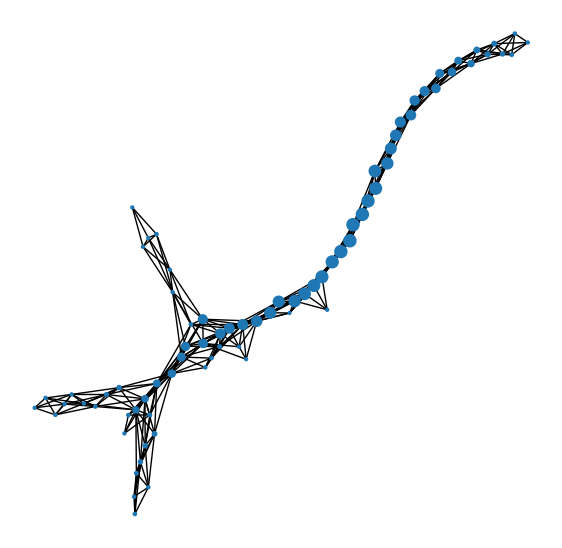

In [2]:
json_path = "data/Mapper_Graphs/FilterBy_family_Cubes_70_Overlap_80.json"
csv_path = "data/Mapper_Graphs/FilterBy_family_Cubes_70_Overlap_80.csv"
orthogroup_path = "data/Orthogroups_filtered.tsv"
example = read_graph(json_path, csv_path, orthogroup_path) # This can take a couple minutes

fig, ax = plt.subplots(figsize=(7,7), dpi=100) 

draw_graph(example, ax)

Let's take a look at what attributes our nodes have now

In [3]:
# Grab the attributes for the "first" node
node_attributes = next(iter(example.nodes.values()))
list(node_attributes.keys())

['orthogroups',
 'Arabidopsis_thaliana.TAIR10.pep.all',
 'Brassica_napus.AST_PRJEB5043_v1.pep.all',
 'GCA_002271885.2_ASM227188v2_protein',
 'GCA_002271895.2_ASM227189v2_protein',
 'GCF_000710875.1_Pepper_Zunla_1_Ref_v1.0_protein',
 'GCF_001879475.1_Asagao_1.1_protein',
 'Ghirsutumv1.1_gene_peptide',
 'ITAG4.0_proteins',
 'Nitab-v4.5_proteins_Edwards2017',
 'Oryza_sativa.IRGSP-1.0.pep.all',
 'Petunia_axillaris_v1.6.2_proteins',
 'Prunus_dulcis.ALMONDv2.pep.all',
 'Prunus_persica_v1.0_peptide',
 'Solanum_aethiopicum.gene',
 'Sorghum_bicolor.Sorghum_bicolor_NCBIv3.pep.all',
 'Vvinifera_145_Genoscope.12X.protein',
 'Zm-B73-REFERENCE-NAM-5.0_Zm00001e.1.protein',
 'Ananas_comosus.F153.pep.all',
 'Brassica_oleracea_capitata_D134-protein',
 'Camelina_sativa.Cs.pep.all',
 'DM_1-3_516_R44_potato.v6.1.hc_gene_models.pep',
 'Gmax_275_Wm82.a2.v1.protein',
 'HFTH1.gene.pep',
 'Hordeum_vulgare.IBSC_v2.pep.all',
 'Pisum_sativum_v1a_prot',
 'Pvulgaris_442_v2.1.protein',
 'PyrusCommunis_BartlettDHv2.0.

So from this we can see each node has a bunch of attributes. The first being orthogroups, which is a list of what orthogroups are contained by that node (cluster). Furthermore, we have the corresponding genes for each species belonging to those orthogroups also contained in those nodes.

In [4]:
# Arabidopsis genes in the first node
node_attributes['Arabidopsis_thaliana.TAIR10.pep.all']

['AT4G17240.1',
 'AT4G17240.2',
 'AT4G02800.1',
 'AT1G08590.1',
 'AT4G28650.1',
 'AT3G01015.1',
 'AT5G15510.1',
 'AT5G15510.2',
 'AT5G15510.3',
 'AT5G15510.4',
 'AT3G57060.1',
 'AT3G57060.2',
 'AT3G57060.3']

In [5]:
def get_all_present_genes(G, species_label):
    # Since we are just concerned about uniqueness we can use a set.
    all_genes = set()
    for attributes in G.nodes.values():
        all_genes.update(set(attributes[species_label]))
    return all_genes

arabidopsis_genes = get_all_present_genes(example, 'Arabidopsis_thaliana.TAIR10.pep.all')
print(len(arabidopsis_genes))

12164


In [7]:
# Print 10 gene names
list(arabidopsis_genes)[:10]

['AT3G13330.1',
 'AT5G66530.3',
 'AT5G57040.1',
 'AT1G69390.1',
 'AT2G27402.2',
 'AT4G22350.4',
 'AT4G27040.3',
 'AT1G25510.1',
 'AT1G72660.4',
 'AT1G68780.1']

## TO-DO:
- Convert arabidopsis gene names to GO terms
- Output study, population, and gene files
- Run find_enrichment.py on those files